# Features Exploration

In this notebook we explore the features to be extracted and tested in the different models. As in the `DataProcessor` class, we will eventually create a class for feature extraction ( `on-loading` extraction ).

In [40]:
import matplotlib.pyplot as plt
from tqdm import tqdm
import seaborn as sns
import pandas as pd
import numpy as np
import scipy
import cv2
import os

BASE_DATA_DIR = os.path.join('data', 'train')
TRAINING_SET_FILE = os.path.join('data', 'training_set.csv')

Define the data loading scheme:

In [41]:
from utils.preprocessing import DataProcessor

# load training data
training_data = pd.read_csv( TRAINING_SET_FILE )

# define the preprocessing scheme
settings = { 'id': 'test', 'image_size': (256, 256), 'noise': True, 'invert': True, 'sharpening': True }
data_processor = DataProcessor(data_dir=BASE_DATA_DIR, settings=settings)

## 1. Feature Extraction:

Let's define and visualise some relevant features:

In [42]:
from skimage.feature import local_binary_pattern, hog, graycomatrix, graycoprops
from skimage.measure import moments_central, moments_normalized
from skimage import filters, morphology
from scipy import stats

def compute_binary_img( image ):
    """ Computes the binary [0 and 1] of the image, showing the contours and closing some imperfections. """
    binary = img > filters.threshold_otsu(img)
    clean = morphology.remove_small_objects(binary, binary.size // 100.0, connectivity=2)
    closed = morphology.binary_closing(clean)
    region = morphology.remove_small_holes(closed, binary.size // 100.0, connectivity=2).astype( np.float32 )
    return cv2.normalize( region, None, 0, 1, norm_type=cv2.NORM_MINMAX, dtype=cv2.CV_8UC1)

def extract_hu_moments( image ):
    """ Calculate Hu Moments """
    moments = cv2.moments( image )
    hu_moments = cv2.HuMoments( moments ).flatten()
    return hu_moments

def extract_fourier_descriptors(image, num_descriptors=30):
    """ Extract features from the Fourier transform of the image """
    bin_img = compute_binary_img(image)
    contours, _ = cv2.findContours( bin_img, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
    total_values = num_descriptors * 2

    if len(contours) > 0:
        contour = contours[0]
        contour = contour[:, 0, :]
        fourier_coeffs = np.fft.fft(contour, axis=0)[:num_descriptors]
        output = fourier_coeffs.flatten()
        if ( len(output) < total_values ):
            diff = total_values - len(output)
            return np.concatenate([output, np.full(diff, np.mean(output))])
    else:
        output = np.empty(total_values)
        output.fill(np.nan)
    return output

def extract_gabor_features(image, num_orientations=8, num_scales=4, num_lambdas=4):
    """ Calculate features from applying Gabor filters to the image """
    filter_ksize = 3 if image.shape[0] <= 256 else 5

    # create combinations of rotations and scales
    combinations_values = []
    for theta in np.arange(start=0, stop=np.pi, step=(np.pi / num_orientations)):
        for sigma in range(1, num_scales + 1):
            for wave in range(1, num_lambdas + 1):
                wavelength = 5 * wave

                # get the gabor kernel from cv2 and convolve it with the image
                gabor_kernel = cv2.getGaborKernel( (filter_ksize, filter_ksize), sigma, theta, wavelength, 0.5, 0, ktype=cv2.CV_32F)
                gabor_image = cv2.filter2D(image, cv2.CV_8UC3, gabor_kernel)
                combinations_values.append(gabor_image.mean())

    # compute gabor features
    gmin, gmax = np.min(combinations_values), np.max(combinations_values)
    gabor_features = [*combinations_values, gmin, gmax, (gmax - gmin) / gmin]
    return np.array(gabor_features)


def extract_basic_intensity_statistics(image):
    """ Perform some basic pixel intensity statistics """
    mean = np.mean(image)
    std = np.std(image)
    kurtosis = stats.kurtosis(image.flatten())
    skew = stats.skew(image.flatten())
    return np.array( [mean, std, kurtosis, skew] )

def extract_local_binary_patterns(image, num_points=24, radius=3):
    """ Computes the LBP image and then extracts the relevant histograms from it."""
    lbp_image = local_binary_pattern(image, num_points, radius, method="uniform")
    hist, _ = np.histogram(lbp_image.ravel(), bins=np.arange(0, num_points + 3), range=(0, num_points + 2))
    hist = hist.astype("float")
    hist /= (hist.sum() + 1e-6)
    return hist

def extract_histogram_of_oriented_gradients(image, num_bins=9):
    """ It selects a cell size depending on the image_size and compute the HOG"""
    ksize = 16 + int( 8 * image.shape[0] // 256 )
    hog_features = hog( image, orientations=num_bins, pixels_per_cell=(ksize, ksize), cells_per_block=(1, 1), visualize=True)
    return hog_features

def extract_haralick_features(image, num_angles=8):
    """ Calculates the gray co-occurence matrix of the image. From the co-matrix, calculates the
        relevant features.
    """
    angles = [i * (np.pi / num_angles) for i in range(num_angles)]
    graycomat = graycomatrix(image, distances=[1], angles=angles)

    haralick_features = []
    for prop_name in ["contrast", "dissimilarity", "homogeneity", "energy", "correlation"]:
        feature = graycoprops(graycomat, prop_name).ravel()
        haralick_features.extend(feature)
    return np.array(haralick_features)


Let's check the extraction of these features:

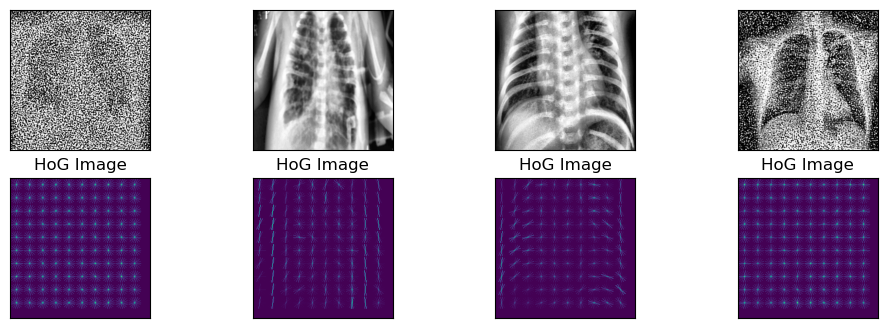

Geometric Features shape: (135,)
Intensity Features shape: (135,)
Texture Features shape: (966,)


In [47]:
SAMPLE_SIZE = 4

random_samples = np.random.choice( training_data['file'].values, size=SAMPLE_SIZE, replace=False,  )
np.random.shuffle( random_samples )

fig, ax = plt.subplots(2, SAMPLE_SIZE, figsize=(3 * SAMPLE_SIZE, 4))
for num in range( SAMPLE_SIZE ):    
    img = data_processor.read_image( random_samples[num] )
    img = data_processor.apply_preprocessing( img )
    ax[0, num].imshow(img, cmap='gray'), ax[0, num].set_xticks([]), ax[0, num].set_yticks([])
    
    binary_image = compute_binary_img( img )
    
    # extract features
    hu_moments = extract_hu_moments( img )
    fourier_features = extract_fourier_descriptors( binary_image, num_descriptors=64 )
    geometric_features = np.concatenate([ hu_moments, fourier_features ])
    
    gabor_features = extract_gabor_features( img, num_orientations=8, num_scales=4, num_lambdas=4)
    basic_features = extract_basic_intensity_statistics( img )
    intensity_features = np.concatenate([ gabor_features, basic_features])
    
    lbp_features = extract_local_binary_patterns( img )
    hog_features, hog_img = extract_histogram_of_oriented_gradients( img )
    haralick_features = extract_haralick_features( img )    
    texture_features = np.concatenate([ lbp_features, hog_features, haralick_features])
    
    # concatenate all features
    ax[1, num].imshow(hog_img), ax[1, num].set_xticks([]), ax[1, num].set_yticks([])
    ax[1, num].set_title('HoG Image')

# check the dimensions of the features
plt.show()
print("Geometric Features shape:", geometric_features.shape)
print("Intensity Features shape:", intensity_features.shape)    
print("Texture Features shape:", texture_features.shape)

We will define a sequence for the next section.

In [9]:

features = [
    # these are "base" features ( maybe not so relevant )
    ('hu', {}), ('hu_bin', {}), ('stats', {}),
    
    # there are more complex features
    ('fourier', {'num_descriptors': 32}),    
    ('gabor', {'num_orientations': 8, 'num_scales': 8, 'num_lambdas': 4}), 
    ('lbp', {'num_points': 32, 'radius':3}),
    ('hog', {'num_bins': 9}),
    ('haralick', {'num_angles': 8})
]

functions = {
    'hu': extract_hu_moments,
    'hu_bin': lambda img: extract_hu_moments(compute_binary_img(img)),
    'fourier': extract_fourier_descriptors,
    'gabor': extract_gabor_features,
    'stats': extract_basic_intensity_statistics,
    'lbp': extract_local_binary_patterns,
    'hog': extract_histogram_of_oriented_gradients,
    'haralick': extract_haralick_features,
}

features_extractor = lambda img: { ft: functions[ft](img, **params) for ft, params in features }

## 2. Feature Exploration

The idea now is to check some `min and max` values, the distribution of the features and to check if some normalisation may be needed. Ideally, we will try to check relations inside the "major" groups ( _geometric_, _intensity_ and _texture_ features ).

**Note:** As before, to get a represention of the training data, we will use a smaller randomly chosen portion.

In [71]:
# extract features from sample dataset (~5%)
data_size = int( 0.01 * len(training_data) )
random_samples = np.random.choice( training_data['file'].values, size=data_size, replace=False )

# extract the features
data_features = { name: [] for name in functions }
for img_name in tqdm(random_samples, desc='Extracting features'):    
    
    # read image
    img = data_processor.read_image( img_name )
    img = data_processor.apply_preprocessing( img )
    
    # extract all the features
    img_features = features_extractor( img )
    [ data_features[name].append( img_features[name]) for name in img_features ]

# transform to arrays and print the shapes
data_features = { name: np.stack(data_features[name]) for name in data_features }
for ft_name in data_features:
    print(f"{ft_name}: {data_features[ft_name].shape}")

Extracting features: 100%|████████████████████████████████████████| 123/123 [00:14<00:00,  8.41it/s]

hu: (123, 7)
hu_bin: (123, 7)
fourier: (123, 64)
gabor: (123, 259)
stats: (123, 4)
lbp: (123, 34)
hog: (123, 900)
haralick: (123, 40)


### 2.1 Group Analysis: Geometric Features

The geometric features are [`Hu Moments`, `Hu Moments (binary)`, `Fourier Descriptors`]. We will check the distribution of the values and some correlations ( to check is the two at the beginning are necessary ).

In [72]:
geometric_features = {
    'hu': data_features['hu'].copy(),
    'hu_bin': data_features['hu_bin'].copy(),
    'fourier_real': np.real(data_features['fourier']).copy(),
    'fourier_imag': np.imag(data_features['fourier']).copy(),
}
for ft_name in geometric_features:
    ft_data = geometric_features[ft_name]
    print(f"{ft_name}: min({ ft_data.min() : .3f}) | max({ ft_data.max() : .3f}) | mean({ ft_data.mean() : .3f})")

hu: min(-0.000) | max( 0.001) | mean( 0.000)
hu_bin: min(-0.000) | max( 0.341) | mean( 0.036)
fourier_real: min(-71216.614) | max( 235399.000) | mean( 1467.585)
fourier_imag: min(-38208.081) | max( 67918.329) | mean( 492.988)


Given the range of the values, we will normalise some values:

In [73]:
for ft_name in ['fourier_real', 'fourier_imag']:
    ft_data = geometric_features[ft_name]
    data_min, data_max = ft_data.min(), ft_data.max()
    print(f"{ft_name} | min-max[ {data_min:0.3f}-{data_max:0.3f} ] | var({ ft_data.var() / (ft_data.mean() + 1e-10)})")
    geometric_features[ft_name] = ( ft_data - ft_data.min() ) / ( ft_data.max() - ft_data.min() + 1e-6)
    print("=" * 5)
    
""" As Hu Moments are a set of 7 different moments, we can normalise them independently """
for ft_name in ['hu', 'hu_bin']:
    hu_data = geometric_features[ft_name]
    for i in range( hu_data.shape[1] ):
        dim_data = hu_data[:, i]
        dim_min, dim_max = dim_data.min(), dim_data.max()
        print(f"{ft_name} (dim={i}) | min-max[ {dim_min:0.3f}-{dim_max:0.3f} ] | var({ dim_data.var() / (dim_data.mean() + 1e-10)})")
        hu_data[:, i] = ( hu_data[:, i] - dim_min ) / ( dim_max - dim_min + 1e-8 )
        
    print("=" * 5)
    geometric_features[ft_name] = hu_data

fourier_real | min-max[ -71216.614-235399.000 ] | var(132873.5219142566)
=====
fourier_imag | min-max[ -38208.081-67918.329 ] | var(40463.45685237599)
=====
hu (dim=0) | min-max[ 0.001-0.001 ] | var(4.267048705613311e-06)
hu (dim=1) | min-max[ 0.000-0.000 ] | var(2.240496947577227e-08)
hu (dim=2) | min-max[ 0.000-0.000 ] | var(1.781958882605827e-11)
hu (dim=3) | min-max[ 0.000-0.000 ] | var(9.716640678101969e-14)
hu (dim=4) | min-max[ -0.000-0.000 ] | var(2.511922943513726e-35)
hu (dim=5) | min-max[ -0.000-0.000 ] | var(7.602142714584591e-22)
hu (dim=6) | min-max[ -0.000-0.000 ] | var(6.567699416814132e-36)
=====
hu_bin (dim=0) | min-max[ 0.174-0.341 ] | var(0.003420051628021033)
hu_bin (dim=1) | min-max[ 0.000-0.011 ] | var(0.0015912752283669118)
hu_bin (dim=2) | min-max[ 0.000-0.006 ] | var(0.0012106351141895513)
hu_bin (dim=3) | min-max[ 0.000-0.001 ] | var(0.00013600980141138274)
hu_bin (dim=4) | min-max[ -0.000-0.000 ] | var(-7.070965748869349e-08)
hu_bin (dim=5) | min-max[ -0.000

Distribution of the values:

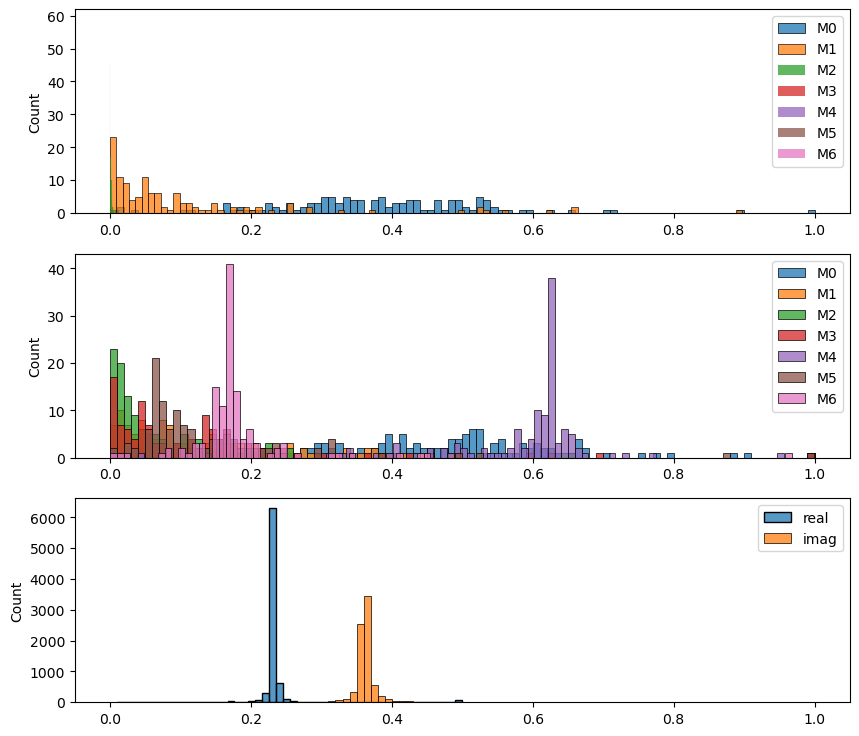

In [74]:
fig, ax = plt.subplots(3, 1, figsize=(10, 9))

# plot the distribution of the values
for i in range( geometric_features['hu'].shape[1] ):
    sns.histplot( geometric_features['hu'][:, i].flatten(), ax=ax[0], bins=100, label=f'M{i}')
    sns.histplot( geometric_features['hu_bin'][:, i].flatten(), ax=ax[1], bins=100, label=f'M{i}')
ax[0].legend(loc='best')
ax[1].legend(loc='best')

sns.histplot( np.clip(geometric_features['fourier_real'].flatten(), a_min=0.01, a_max=0.5), ax=ax[2], bins=50, label='real' )
sns.histplot( geometric_features['fourier_imag'].flatten(), ax=ax[2], bins=100, label='imag' )
ax[2].legend(loc='best')

plt.show()

From the values, specially on the first graph, we can see that `Hu Moments` on the raw image is not the best approach as all the **values are compressed near the 0**. On a first look, `Hu moments` on the binary image looks better, but the **last 3 moments have really low variability** ( it's a good option to remove them too ).

> We are discarding the normal `Hu moments`.

We can also see that `Fourier Descriptors` values follow a normal distribution for both `real` and `imaginary` part. We will check how correlated are these two values:

In [89]:
from scipy import stats

correlations = []
for real, imag in zip( geometric_features['fourier_real'], geometric_features['fourier_imag']):
    correlations.append( stats.pearsonr(real, imag)[0] )
correlations = np.array( correlations )
print("Correlation Stats: ")
print(f" -min({correlations.min()}) | -max({correlations.max()}) | -mean({correlations.mean()})")

Correlation Stats: 
 -min(-0.16410091906050422) | -max(0.21924632151600826) | -mean(-0.017113857290287682)


We can see the values are quite cose to 0 in correlation, so we could keep both.

### 2.2 Group Analysis: Intensity features

We follow a similar analysis, the `Pixel Intesity` features are: `[Gabor Filters, Pixel Stats]`


In [22]:
intensity_features = {
    'gabor': data_features['gabor'].copy(),
    'stats': data_features['stats'].copy(),
}
for ft_name in intensity_features:
    ft_data = intensity_features[ft_name]
    print(f"{ft_name}: min({ ft_data.min() : .3f}) | max({ ft_data.max() : .3f}) | mean({ ft_data.mean() : .3f})")

gabor: min( 0.025) | max( 254.675) | mean( 235.758)
stats: min(-1.468) | max( 165.819) | mean( 50.714)


For the normalisation, we will take care of the fact that `stats` is the union of 4 different values from the image ( similar to Hu ). 

On the other hand, something similar ocurrs with `Gabor`, each entry (until the last 3) is `mean()` value of the image after applying the corresponding filter. The last three are statistics based on these values.

In [23]:
for ft_name in ['stats', 'gabor']:
    ft_data = intensity_features[ft_name]
    for i in range( ft_data.shape[1] ):
        dim_data = ft_data[:, i]
        dim_min, dim_max = dim_data.min(), dim_data.max()
        print(f"{ft_name} (dim={i}) | min-max([{dim_min:0.4f}-{dim_max:0.4f}]) | var({ dim_data.var() / dim_data.mean()})")
        
        ft_data[:, i] = ( ft_data[:, i] - dim_min ) / ( dim_max - dim_min + 1e-6 )

    print("=" * 5)
    intensity_features[ft_name] = ft_data

stats (dim=0) | min-max([92.0848-165.8190]) | var(0.7754970867031302)
stats (dim=1) | min-max([53.6057-93.6813]) | var(0.7704784689195986)
stats (dim=2) | min-max([-1.4683--0.1316]) | var(-0.024057564464025176)
stats (dim=3) | min-max([-0.7903-0.3834]) | var(-0.20258299214521222)
=====
gabor (dim=0) | min-max([170.1615-247.5452]) | var(0.836018755063548)
gabor (dim=1) | min-max([180.0147-253.1461]) | var(0.7929899241782349)
gabor (dim=2) | min-max([181.4848-253.6093]) | var(0.7723847675594208)
gabor (dim=3) | min-max([182.0361-253.7352]) | var(0.7639465120861616)
gabor (dim=4) | min-max([175.2683-250.4544]) | var(0.8241706542886797)
gabor (dim=5) | min-max([186.0413-254.3833]) | var(0.6988936773363178)
gabor (dim=6) | min-max([187.5159-254.5240]) | var(0.6724458862695275)
gabor (dim=7) | min-max([188.0211-254.5616]) | var(0.6623613096181553)
gabor (dim=8) | min-max([176.2472-251.0752]) | var(0.8189509005190835)
gabor (dim=9) | min-max([187.1356-254.4887]) | var(0.6784301896984322)
gabo

These results are meaningful for the `Gabor filters`, each filter is defined based on `orientation x scale x lambda` (in that order). At the definition of the functions we iterate first over `orientations` and secondly over `scales` and lastly over `lambdas`.

> We can see that at `scale=4`, the variablity of the data is the less. It may be possible to delete this `scale`.

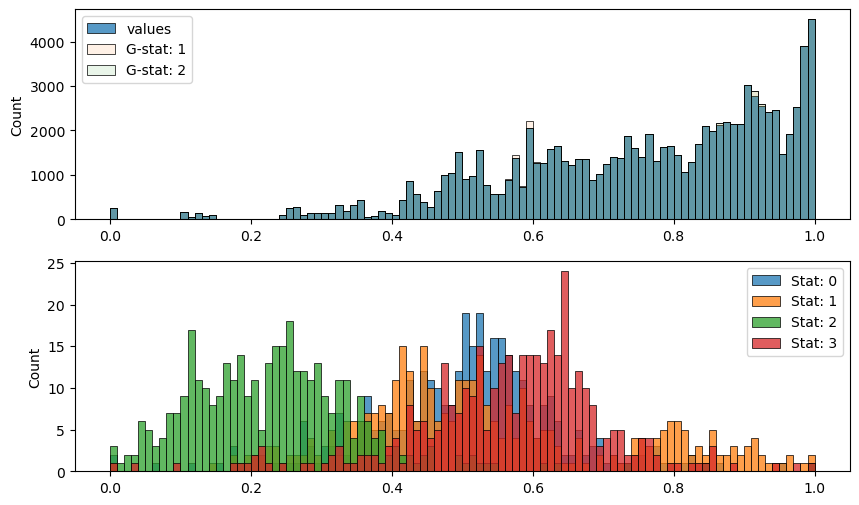

In [29]:
fig, ax = plt.subplots(2, 1, figsize=(10, 6))

# plot the distribution of the values
sns.histplot( intensity_features['gabor'][:-3:].flatten(), ax=ax[0], bins=100, label='values')
for i in range( 1, 3 ):
    sns.histplot( intensity_features['gabor'][:-i].flatten(), ax=ax[0], bins=100, alpha=0.1, label=f'G-stat: {i}')
ax[0].legend(loc='best')

for i in range( intensity_features['stats'].shape[1] ):
    sns.histplot( intensity_features['stats'][:, i].flatten(), ax=ax[1], bins=100, label=f'Stat: {i}')
ax[1].legend(loc='best')
plt.show()

From the `Gabor` graph, we can see that both statistics included follow the same distribution as the values. Given this we decide to delte them.

### 2.3 Texture Features:

We finish the analysis looking at the `texture` features:

In [50]:
texture_features = {
    'lbp': data_features['lbp'].copy(),
    'hog': data_features['hog'].copy(),
    'haralick': data_features['haralick'].copy(),
}
for ft_name in texture_features:
    ft_data = texture_features[ft_name]
    print(f"{ft_name}: min-max[{ft_data.min():.3f}-{ft_data.max():.3f}] | var({ ft_data.var()/ft_data.mean() :.3f})")

lbp: min-max[0.000-0.679] | var(0.132)
hog: min-max[0.000-1.000] | var(0.047)
haralick: min-max[0.007-14428.873] | var(7161.976)


In [51]:
for ft_name in ['lbp', 'hog']:
    ft_data = texture_features[ft_name]
    data_min, data_max = ft_data.min(), ft_data.max()
    print(f"{ft_name} | min-max[ {data_min:0.3f}-{data_max:0.3f} ] | var({ ft_data.var() / (ft_data.mean() + 1e-10)})")
    texture_features[ft_name] = ( ft_data - ft_data.min() ) / ( ft_data.max() - ft_data.min() + 1e-6)
    print("=" * 5)
    
""" For Haraclick it makes sense to normalise over the same dimension """
for ft_name in ['haralick']:
    ft_data = texture_features[ft_name]
    for i in range( ft_data.shape[1] ):
        dim_data = ft_data[:, i]
        dim_min, dim_max = dim_data.min(), dim_data.max()
        print(f"{ft_name} (dim={i}) | min-max[ {dim_min:0.3f}-{dim_max:0.3f} ] | var({ dim_data.var() / (dim_data.mean() + 1e-10)})")
        ft_data[:, i] = ( ft_data[:, i] - dim_min ) / ( dim_max - dim_min + 1e-8 )
    texture_features[ft_name] = ft_data
    print("=" * 5)

lbp | min-max[ 0.000-0.679 ] | var(0.13158220801551504)
=====
hog | min-max[ 0.000-1.000 ] | var(0.04678039812657203)
=====
haralick (dim=0) | min-max[ 60.161-9212.995 ] | var(4860.347500405889)
haralick (dim=1) | min-max[ 60.161-9212.995 ] | var(4860.347500405889)
haralick (dim=2) | min-max[ 113.477-14346.971 ] | var(7544.65214370557)
haralick (dim=3) | min-max[ 46.178-9353.510 ] | var(4915.53267310772)
haralick (dim=4) | min-max[ 46.178-9353.510 ] | var(4915.53267310772)
haralick (dim=5) | min-max[ 46.178-9353.510 ] | var(4915.53267310772)
haralick (dim=6) | min-max[ 125.801-14428.873 ] | var(7535.870023318754)
haralick (dim=7) | min-max[ 60.161-9212.995 ] | var(4860.347500405888)
haralick (dim=8) | min-max[ 4.906-72.644 ] | var(23.203102647629198)
haralick (dim=9) | min-max[ 4.906-72.644 ] | var(23.203102647629198)
haralick (dim=10) | min-max[ 7.240-95.488 ] | var(30.533269834648983)
haralick (dim=11) | min-max[ 4.316-73.254 ] | var(25.02421567607964)
haralick (dim=12) | min-max[ 4.

The `Haralick` values are sequence of properties measured at 8 different angles. We can see that there are some measurements with low `variability`, **we could remove them**. Also, there are some repeated values for the same angles.

About `HoG`, given the vast number of features we are getting, there should probably be a feature reduction step afterwards.

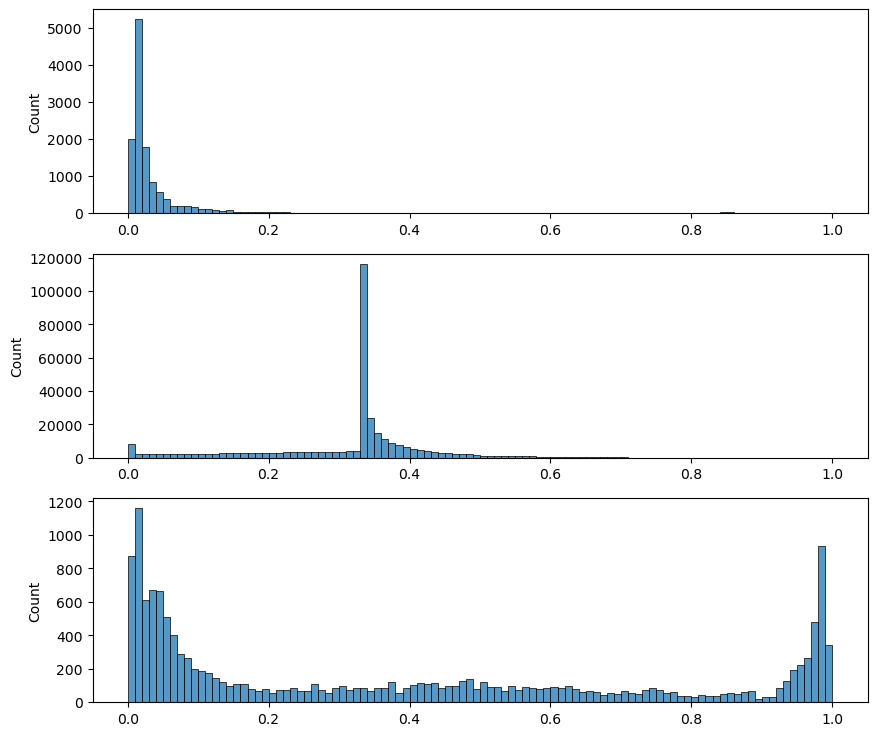

In [52]:
fig, ax = plt.subplots(3, 1, figsize=(10, 9))

# plot the distribution of the values
sns.histplot( texture_features['lbp'].flatten(), ax=ax[0], bins=100 )
sns.histplot( texture_features['hog'].flatten(), ax=ax[1], bins=100 )
sns.histplot( texture_features['haralick'].flatten(), ax=ax[2], bins=100 )
plt.show()

The distribution look better than expected and no evident comment is done.

### 2.4 Define hyperparamenters:

From the previous exploration we can define relevant hyperparameters for the feature extraction. In general the `feature_extraction` hyperparameters won't be really touched during training.

Nevertheless, we will make some validation regarding which features to utilise and how to group them too ( this is going to be explored next ).

In [50]:
from utils.features import DataFeatures

features = [
    
    # these are "base" features ( maybe not so relevant )
    ('hu_bin', {}), ('stats', {}),
    
    # there are more complex features
    ('fourier', {'num_descriptors': 32}),
    ('gabor', {'num_orientations': 8, 'num_scales': 3, 'num_lambdas': 4}), 
    ('lbp', {'num_points': 32, 'radius':3}),
    # ('hog', {'num_bins': 9}),
    ('haralick', {'num_angles': 4})
]

features_extractor = DataFeatures( features )

## 3. Grouping features

Now the idea is to check if we can apply any _dimensionality reduction_ technique specifically on the features/groups we extracted.

> This will be one of the search parameters when we are looking for optimising our models.

The idea would to check for some reductions and then visualising them. We will test `PCA`.

**Note:** `LDA` would yield poor results here as the number of components is bounded by `#classes - 1 = 2` in our case.

In [51]:
# extract features from sample dataset (~10%)
data_size = int( 0.1 * len(training_data) )
random_files = np.random.choice( training_data['file'].values, size=data_size, replace=False )
sample_data = training_data[ training_data['file'].isin(random_files) ]

# extract the features
data_features, labels = { ft_name: [] for ft_name in features_extractor.all_features }, []
for idx, ( file_name, label, _ ) in tqdm(sample_data.iterrows(), desc='Extracting features', total=data_size):
    
    # read image
    img = data_processor.read_image( file_name )
    img = data_processor.apply_preprocessing( img )
    
    # extract all the features
    img_features = features_extractor.extract_features( img )    
    [ data_features[name].append( img_features[name]) for name in img_features ]
    labels.append( label )

# transform to arrays and print the shapes
data_features = { name: np.stack(data_features[name]) for name in data_features }
labels = np.array( labels )

Extracting features: 100%|██████████████████████████████████████| 1236/1236 [01:27<00:00, 14.20it/s]


Let's start to analyse using `PCA`, we will use the _Elbow method_ to check the best _variance_ explanation on the number of compoenents.

Original shape: (1236, 132)


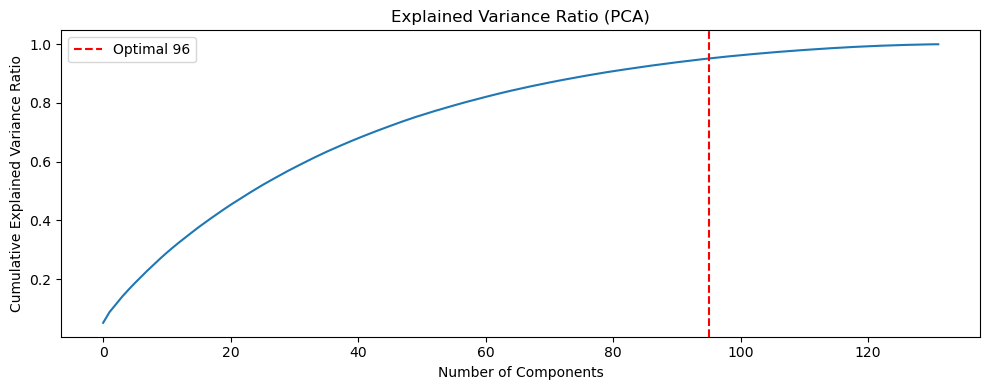

In [52]:
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA

# GROUP TO ANALYSE
features_to_analyse = [ 'hu_bin', 'fourier_real', 'fourier_imag' ]
features_to_analyse = np.concatenate( [data_features[ft] for ft in features_to_analyse], axis=1)
print("Original shape:", features_to_analyse.shape)

# we will measure the quantities
scaler = StandardScaler()
normalised_features = scaler.fit_transform( features_to_analyse )

plt.figure(figsize=(10, 4))

# PCA
pca = PCA()
pca_result = pca.fit_transform(normalised_features)
explained_var_ratio = np.cumsum(pca.explained_variance_ratio_)

plt.plot(explained_var_ratio)
plt.title('Explained Variance Ratio (PCA)')
plt.xlabel('Number of Components'), plt.ylabel('Cumulative Explained Variance Ratio')

# use elbow to get "best n_components"
def find_elbow(data):
    cumulative_variance = np.cumsum( data ) / np.sum(data)
    return np.argmax(cumulative_variance >= 0.95) + 1

# Determine optimal components for PCA
optimal_pca_components = find_elbow(pca.explained_variance_ratio_)
plt.axvline(x=optimal_pca_components - 1, linestyle='--', color='red', label=f'Optimal {optimal_pca_components}')
plt.legend(loc='best')
plt.tight_layout()
plt.show()

The most interesting results can be seen from the `intensity` feautures, where the optimal number of components is 1 ( this is, only one component carries 95% of the variability ).